# Lead Segmentation

In [34]:
import os
import cv2
import numpy as np
from ultralytics import YOLO

NUM_IMAGES = 20
CONF_THRESHOLD = 0.7

TEST_IMAGE_DIR = '../data/clean-ecg-6by2'
SAVE_ROOT =   '../data/final-outputs'
MODEL_PATH = '../models/yolo-segmentation-weights.pt'

# Load model
model = YOLO(MODEL_PATH)

# Read image files
image_files = [f for f in os.listdir(TEST_IMAGE_DIR) if f.endswith((".jpg", ".png"))]
os.makedirs(SAVE_ROOT, exist_ok=True)

# Mapping from class ID to name
class_names = model.names

ORDERED_WAVE_LABELS = ['I', 'V1', 'II', 'V2', 'III', 'V3',
                       'aVL', 'V4', 'aVR', 'V5', 'aVF', 'V6', 'II_ext']

In [35]:
def merge_boxes(box1, box2):
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])
    return [x1, y1, x2, y2]

def sort_wave_boxes(boxes):
    # Group into rows based on y-coordinate proximity (30 pixel threshold)
    rows = []
    for box in sorted(boxes, key=lambda b: b[1]):  # sort by y1
        placed = False
        for row in rows:
            if abs(row[-1][1] - box[1]) < 30:  # y1 close enough
                row.append(box)
                placed = True
                break
        if not placed:
            rows.append([box])
    # Sort each row left to right
    for row in rows:
        row.sort(key=lambda b: b[0])
    # Flatten and return
    flat = [b for row in rows for b in row]
    return flat

for idx in range(15):
    image_file = image_files[idx]
    image_path = os.path.join(TEST_IMAGE_DIR, image_file)
    base_name = os.path.splitext(image_file)[0]

    # Inference
    results = model(image_path)[0]

    # Read and prepare image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

    # Get class 0 boxes above threshold
    wave_boxes = []
    for box in results.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if conf >= CONF_THRESHOLD and cls_id == 0:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            wave_boxes.append([x1, y1, x2, y2])

    # Special handling for II extended
    if len(wave_boxes) == 14:
        wave_boxes[-2:] = [merge_boxes(wave_boxes[-2], wave_boxes[-1])]

    # Sort in row-wise (top to bottom, then left to right) order
    wave_boxes = sort_wave_boxes(wave_boxes)

    # Save full image with real class labels
    for box in results.boxes:
        conf = float(box.conf[0])
        if conf < CONF_THRESHOLD:
            continue
        cls_id = int(box.cls[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        label = f"{class_names[cls_id]} ({conf:.2f})"
        color = (0, 255, 0)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img_rgb, label, (x1, max(y1 - 10, 10)), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)

    # Save cropped waves with correct label names, prefix with idx
    for i, box in enumerate(wave_boxes):
        if i >= len(ORDERED_WAVE_LABELS):
            break
        label = ORDERED_WAVE_LABELS[i]
        x1, y1, x2, y2 = box
        crop = img[y1:y2, x1:x2]
        crop_path = os.path.join(SAVE_ROOT, f"{idx}_{label}.jpg")
        cv2.imwrite(crop_path, crop, [cv2.IMWRITE_JPEG_QUALITY, 100])

    # Save full annotated image, prefix with idx
    full_img_path = os.path.join(SAVE_ROOT, f"{idx}_full.jpg")
    cv2.imwrite(full_img_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 100])


image 1/1 /home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../data/clean-ecg-6by2/130_6by2.jpg: 320x640 14 lead_containers, 1 label_II, 1 label_III, 1 label_aVR, 1 label_aVL, 1 label_aVF, 1 label_V1, 1 label_V2, 1 label_V3, 1 label_V4, 1 label_V5, 1 label_V6, 227.5ms
Speed: 3.1ms preprocess, 227.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../data/clean-ecg-6by2/254_6by2.jpg: 320x640 13 lead_containers, 1 label_II, 1 label_III, 1 label_aVR, 1 label_aVL, 1 label_aVF, 1 label_V1, 1 label_V2, 1 label_V3, 1 label_V4, 1 label_V5, 1 label_V6, 228.5ms
Speed: 3.1ms preprocess, 228.5ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../data/clean-ecg-6by2/362_6by2.jpg: 320x640 13 lead_containers, 1 label_II, 1 label_III, 1 label_aVR, 1 label_aVL, 1 label_aVF, 1 label_V1, 1 label_V2, 1 label_V3, 1 label_V4, 1 lab

# Grid Seperation

In [36]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from glob import glob

In [37]:

def extract_grid_mask(img, closing_kernel=5, length_frac=0.8):
    """
    img:       BGR or grayscale input
    closing_kernel: size of small kernel to close grid dots ([3,3] works well)
    length_frac: fraction of img width/height that a line must span to be kept
    """
    # 1) Grayscale + adaptive threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim==3 else img
    binarized = cv2.adaptiveThreshold(gray,255,
                                      cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY_INV,
                                      blockSize=11, C=5)

    # 2) Close gaps (connect dots into lines)
    kernel_close = np.ones((closing_kernel, closing_kernel), np.uint8)
    closed = cv2.morphologyEx(binarized, cv2.MORPH_CLOSE, kernel_close)

    h, w = gray.shape

    # 3a) Extract horizontal lines via opening
    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(w*1), 1))
    horiz_lines = cv2.morphologyEx(closed, cv2.MORPH_OPEN, horiz_kernel)

    # 3b) Extract vertical lines via opening
    vert_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(h*0.5)))
    vert_lines = cv2.morphologyEx(closed, cv2.MORPH_OPEN, vert_kernel)

    # 4) Filter by length: remove any connected component shorter than threshold
    def filter_by_length(mask, axis_len):
        # keep only components whose bounding‐box along axis >= length_frac*axis_len
        nb_components, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        out = np.zeros_like(mask)
        min_len = length_frac * axis_len
        for i in range(1, nb_components):
            x, y, w0, h0, area = stats[i]
            if axis_len==w:    # horizontal mask
                if w0 >= min_len:
                    out[labels==i] = 255
            else:              # vertical mask
                if h0 >= min_len:
                    out[labels==i] = 255
        return out

    horiz_clean = filter_by_length(horiz_lines, w)
    vert_clean  = filter_by_length(vert_lines,  h)

    # 5) Combine
    grid_mask = cv2.bitwise_or(horiz_clean, vert_clean)
    return grid_mask


def visualize(image, grid_mask):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[1].imshow(grid_mask, cmap='gray')
    axs[1].set_title("Detected Grid")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [41]:
import os
import random

IMAGE_DIR = '../data/final-outputs'

img_paths = []
for fname in os.listdir(IMAGE_DIR):
    fname_lower = fname.lower()
    if (
        fname_lower.endswith(('.png', '.jpg', '.jpeg')) and
        'full' not in fname_lower and
        'grid' not in fname_lower and
        'wave' not in fname_lower and
        'waveform' not in fname_lower
    ):
        img_paths.append(os.path.join(IMAGE_DIR, fname))

sample_paths = random.sample(img_paths, min(15, len(img_paths)))

In [42]:
img_paths[1]

'../data/final-outputs/6_V6.jpg'

In [43]:
len(img_paths)

180

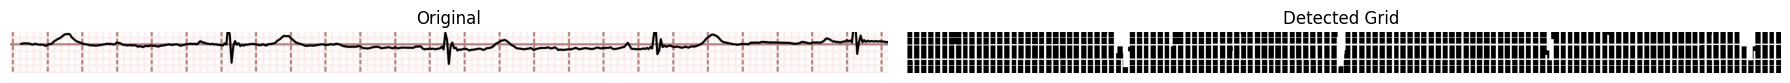

Estimated square width:  16 px (count=82)
Estimated square height: 16 px (count=3)
Selected square size:  80 px


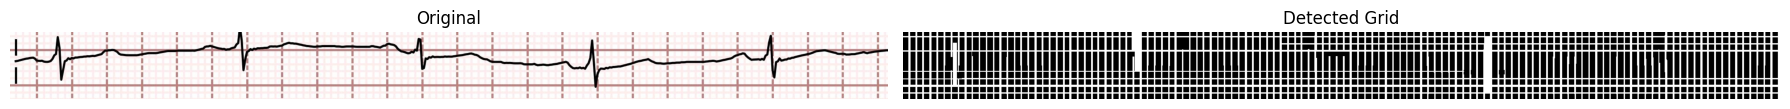

Estimated square width:  16 px (count=78)
Estimated square height: 16 px (count=4)
Selected square size:  80 px


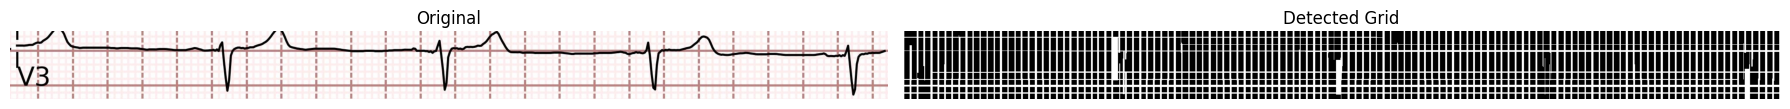

Estimated square width:  16 px (count=73)
Estimated square height: 16 px (count=3)
Selected square size:  80 px


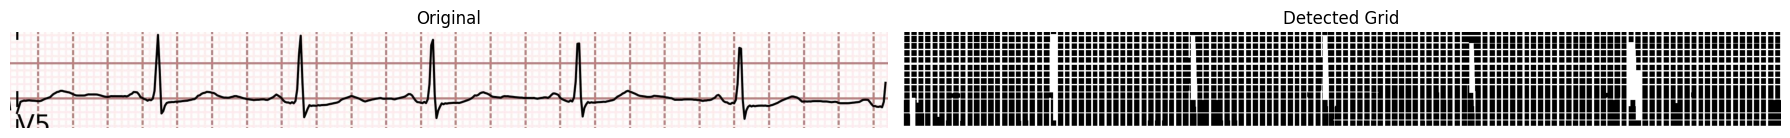

Estimated square width:  16 px (count=78)
Estimated square height: 16 px (count=5)
Selected square size:  80 px


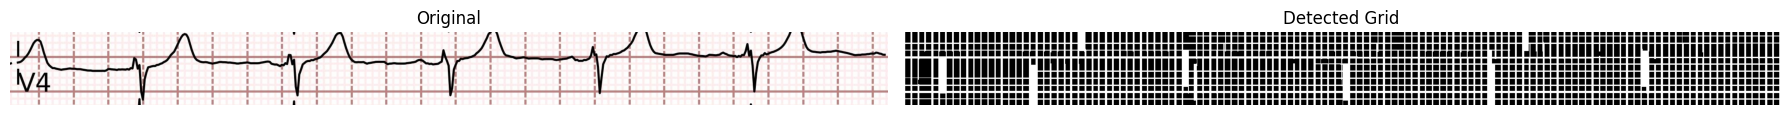

Estimated square width:  16 px (count=68)
Estimated square height: 15 px (count=4)
Selected square size:  80 px


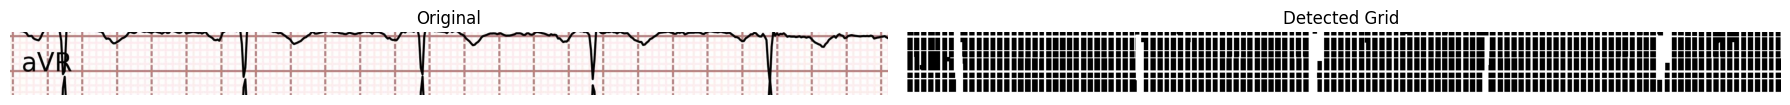

Estimated square width:  16 px (count=73)
Estimated square height: 16 px (count=2)
Selected square size:  80 px


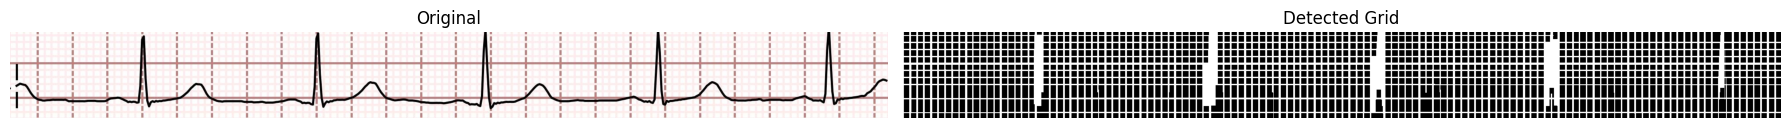

Estimated square width:  16 px (count=82)
Estimated square height: 16 px (count=6)
Selected square size:  80 px


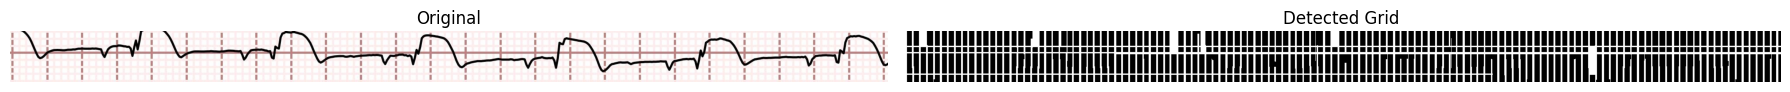

Estimated square width:  16 px (count=65)
Estimated square height: 17 px (count=1)
Selected square size:  80 px


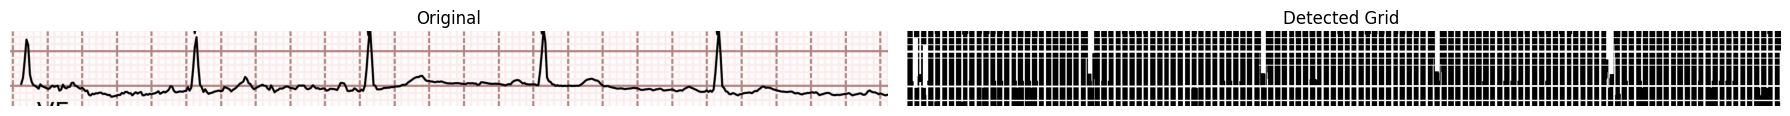

Estimated square width:  16 px (count=66)
Estimated square height: 16 px (count=3)
Selected square size:  80 px


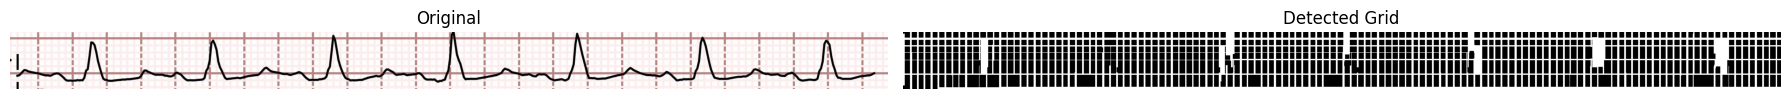

Estimated square width:  16 px (count=73)
Estimated square height: 18 px (count=1)
Selected square size:  80 px


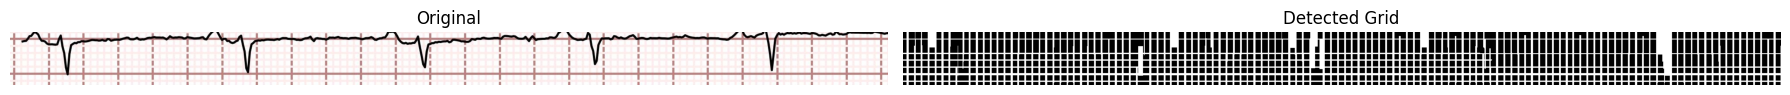

Estimated square width:  16 px (count=78)
Estimated square height: 16 px (count=3)
Selected square size:  80 px


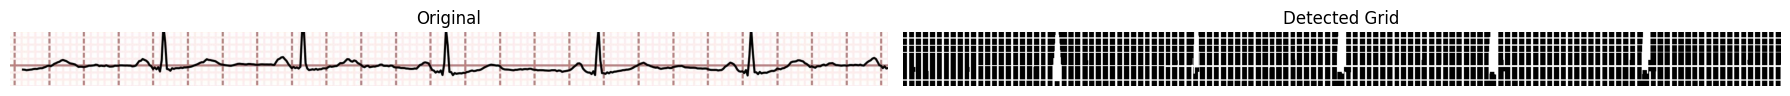

Estimated square width:  16 px (count=78)
Estimated square height: 16 px (count=2)
Selected square size:  80 px


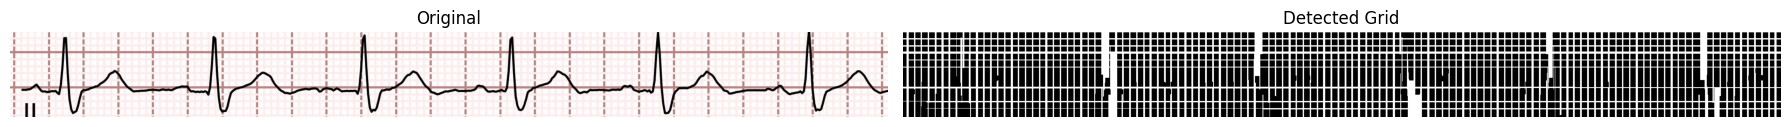

Estimated square width:  16 px (count=67)
Estimated square height: 16 px (count=5)
Selected square size:  80 px


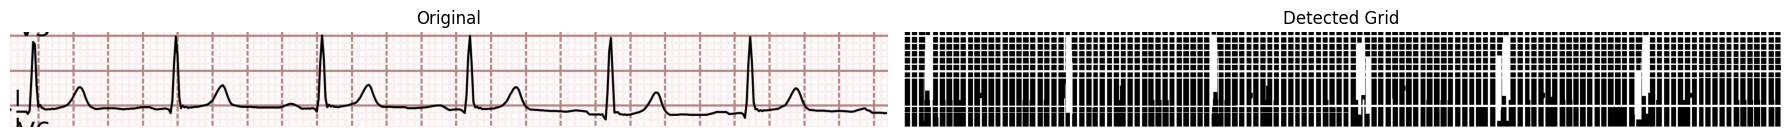

Estimated square width:  16 px (count=65)
Estimated square height: 16 px (count=3)
Selected square size:  80 px


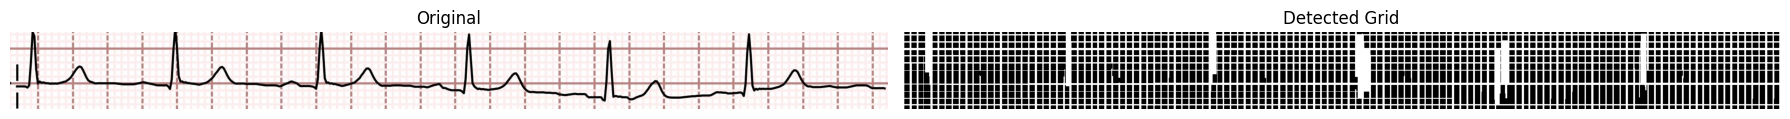

Estimated square width:  16 px (count=71)
Estimated square height: 16 px (count=4)
Selected square size:  80 px


In [49]:
from scipy.signal import find_peaks

images = []
masks = []
sizes = []
orig_names = []

for path in sample_paths:
    img = cv2.imread(path)
    if img is None:
        continue
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(img_gray)
    orig_names.append(os.path.basename(path))
    grid_mask = extract_grid_mask(img, closing_kernel=10, length_frac=0.05)
    masks.append(grid_mask)

    # Save grid mask in the same folder as the original image
    save_dir = os.path.dirname(path)
    orig_base, orig_ext = os.path.splitext(os.path.basename(path))
    grid_mask_name = f"{orig_base}_grid{orig_ext}"

    # Visualization
    visualize(img, grid_mask)

    # 1) Project onto each axis
    vertical_profile   = grid_mask.sum(axis=0)   # sum over rows → strong peaks at vertical lines
    horizontal_profile = grid_mask.sum(axis=1)   # sum over cols → strong peaks at horizontal lines

    # 2) Find the line positions (peaks)
    #    height thresholds assume lines span most of the image
    v_peaks, _ = find_peaks(vertical_profile, height=grid_mask.shape[0] * 0.5)
    h_peaks, _ = find_peaks(horizontal_profile, height=grid_mask.shape[1] * 0.5)

    # 3) Compute spacings between consecutive peaks
    v_spacings = np.diff(v_peaks)   # pixel widths between vertical lines
    h_spacings = np.diff(h_peaks)   # pixel heights between horizontal lines

    # 4) Get mode with tiebreaker (highest)
    def mode_with_tiebreak(data):
        if len(data) == 0:
            return None, 0
        vals, counts = np.unique(data, return_counts=True)
        max_count = counts.max()
        candidates = vals[counts == max_count]
        return candidates.max(), max_count  # highest value among ties + its frequency

    # Get mode values and their frequencies
    avg_square_width,  count_w = mode_with_tiebreak(v_spacings)
    avg_square_height, count_h = mode_with_tiebreak(h_spacings)

    # Decide final square size based on higher frequency
    if count_w > count_h:
        square_size = avg_square_width
    elif count_h > count_w:
        square_size = avg_square_height
    else:
        square_size = max(avg_square_width, avg_square_height)  # tie → choose bigger

    if max(count_h, count_w) > 40: #if there are too many squares then the small squares are being detetcted:
        square_size *= 5

    # Append and print
    sizes.append(square_size)
    print(f"Estimated square width:  {avg_square_width} px (count={count_w})")
    print(f"Estimated square height: {avg_square_height} px (count={count_h})")
    print(f"Selected square size:  {square_size} px")

    orig_base, orig_ext = os.path.splitext(os.path.basename(path))
    grid_mask_name = f"{orig_base}_grid{orig_ext}"
    size_name = f"{orig_base}_size.txt"
    cv2.imwrite(os.path.join(save_dir, grid_mask_name), grid_mask)
    with open(os.path.join(save_dir, size_name), 'w') as f:
        f.write(str(square_size))


# Extract Binary Mask

In [50]:
import torch
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from segmentation_models_pytorch import Unet
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2

/home/abdullah-bin-mansoor/Desktop/ECG Project/ecg_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
import sys
sys.path.append('../wave-binary-mask/scripts')

from ecg_dataset import ECGDataset


In [52]:
# === Paths ===
WEIGHTS_PATH = '../models/unet-binary-masking.pth'  # Update if needed
IMAGE_DIR = '../data/final-outputs'
SAVE_DIR = '../data/final-outputs'
os.makedirs(SAVE_DIR, exist_ok=True)

# === Constants ===
BATCH_SIZE = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
# === Load dataset ===
masks = []
valid_images = sample_paths

test_ds = ECGDataset(sample_paths, mask_paths=None, augment=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

/home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../wave-binary-mask/scripts/ecg_dataset.py:23: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=self.IMG_HEIGHT,
/home/abdullah-bin-mansoor/Desktop/ECG Project/ecg_venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../wave-binary-mask/scripts/ecg_dataset.py:38: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=self.IMG_HEIGHT,
/home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../wave-binary-mask/scripts/ecg_dataset.py:49: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=self.IMG_HEIGHT,


In [57]:
# ---- Load model ----
from segmentation_models_pytorch import Unet

model = Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location="cuda" if torch.cuda.is_available() else "cpu"))
model = model.to(DEVICE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


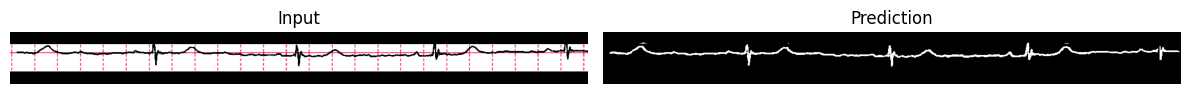

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


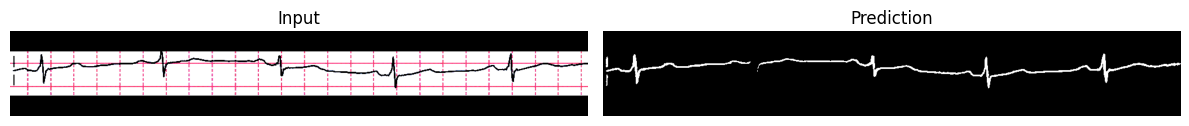

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


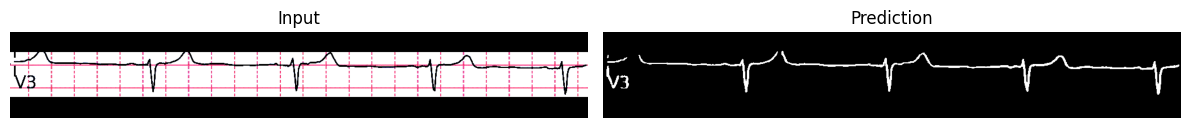

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


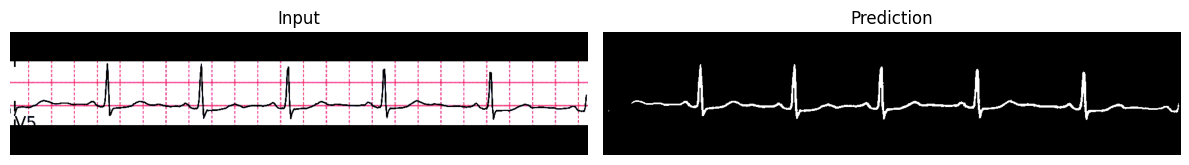

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


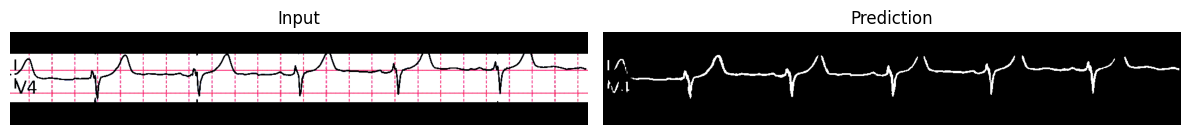

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


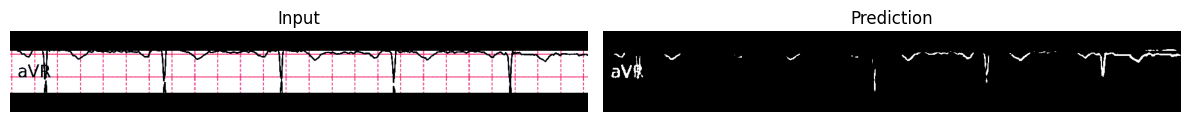

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


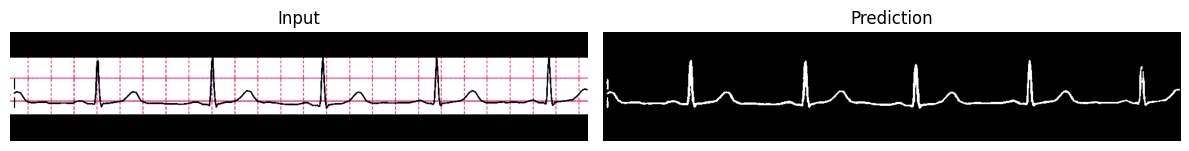

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


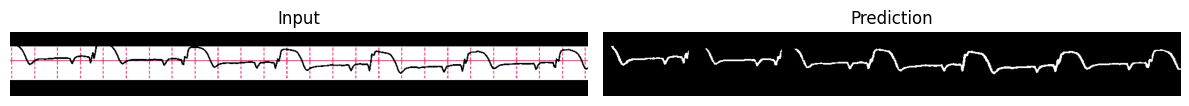

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


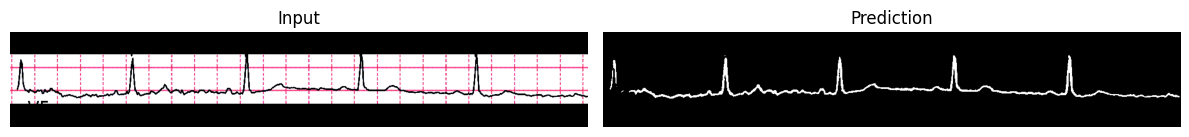

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


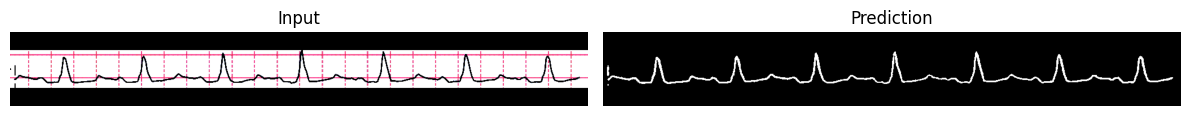

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


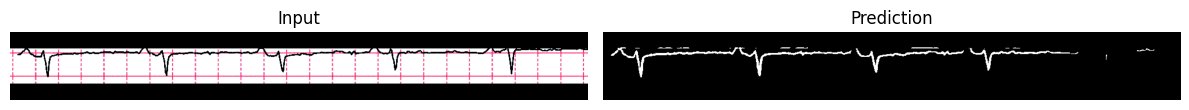

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


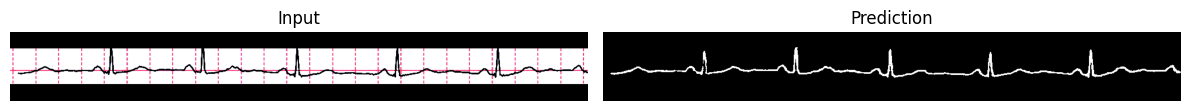

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


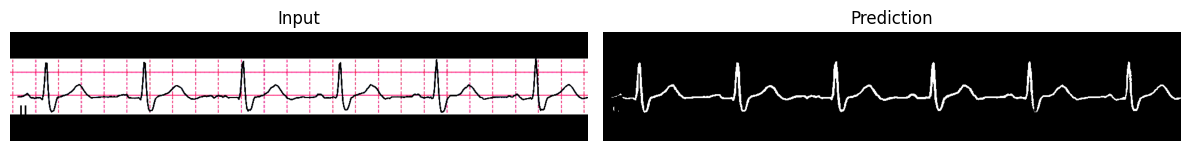

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


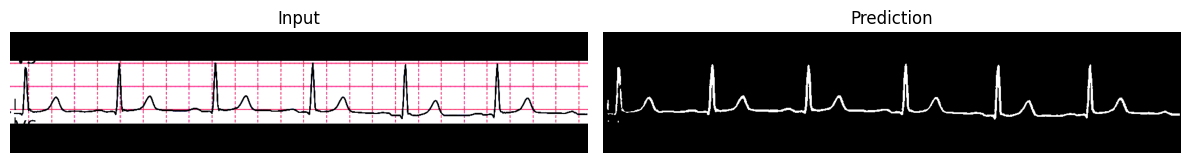

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


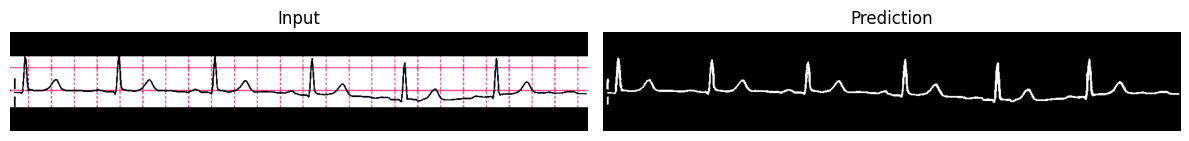

In [124]:
waves = []
# ---- Visualize & Save Predictions ----
def center_crop(tensor, target_h):
    # tensor shape: [C, H, W]
    _, h, w = tensor.shape
    top = (h - target_h) // 2
    return tensor[:, top:top+target_h, :]

def visualize_and_save_predictions(model, dataloader, device, save_dir="./unet_results/test_preds", num_images=10):
    os.makedirs(save_dir, exist_ok=True)
    images_shown = 0

    with torch.no_grad():
        for batch in dataloader:
            images, sizes = batch
            images = images.to(device)
            outputs = torch.sigmoid(model(images)) > 0.5

            for i in range(images.shape[0]):
                if images_shown >= num_images:
                    return

                h, w = sizes[0][0], sizes[1][0]  # Tuple
                h, w = int(h), int(w)

                input_img = center_crop(images[i].cpu(), h)
                pred_mask = center_crop(outputs[i].float().cpu(), h)
                waves.append(pred_mask)

                orig_name = os.path.basename(valid_images[images_shown])
                orig_base, orig_ext = os.path.splitext(orig_name)
                wave_mask_name = f"{orig_base}_wave{orig_ext if orig_ext.lower() in ['.jpg', '.jpeg', '.png'] else '.png'}"
                save_image(pred_mask, os.path.join(save_dir, wave_mask_name))
                
                # Optional plot
                fig, axs = plt.subplots(1, 2, figsize=(12, 4))
                axs[0].imshow(input_img.permute(1, 2, 0))
                axs[0].set_title("Input")
                axs[1].imshow(pred_mask[0], cmap="gray")
                axs[1].set_title("Prediction")
                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                images_shown += 1

# === Run ===
visualize_and_save_predictions(model, test_loader, save_dir=SAVE_DIR, device="cpu", num_images=15)

# Convert the binary mask to a signal

In [125]:
import numpy as np

def binary_mask_to_waveform(mask, square_size, baseline_mode='center'):
    """
    Converts a binary ECG mask to a 1D waveform array.

    Args:
        mask (np.ndarray): Binary mask of shape [H, W] with 1s for wave pixels.
        square_size (int or float): Number of pixels per big square (usually 50 px ≈ 0.5 mV).
        baseline_mode (str): How to estimate the baseline. Options:
            - 'center': middle of image
            - 'mean': mean y of wave pixels
            - 'median': median y of wave pixels

    Returns:
        signal_mv (np.ndarray): 1D waveform in millivolts (float values).
    """
    H, W = mask.shape
    signal_pixels = np.full(W, np.nan)  # one value per column (x/time)

    for x in range(W):
        y_indices = np.where(mask[:, x] > 0)[0]
        if len(y_indices) > 0:
            signal_pixels[x] = y_indices.mean()  # or min() for upper, max() for lower edge

    # Estimate baseline
    if baseline_mode == 'center':
        baseline = H / 2
    elif baseline_mode == 'mean':
        baseline = np.nanmean(signal_pixels)
    elif baseline_mode == 'median':
        baseline = np.nanmedian(signal_pixels)
    elif baseline_mode == 'min':
        baseline = np.nanmin(signal_pixels)
    elif baseline_mode == 'max':
        baseline = np.nanmax(signal_pixels)
    elif baseline_mode == 'zero':
        baseline = 0.0
    elif baseline_mode == 'mode':
        from scipy import stats
        mode_value, _ = stats.mode(signal_pixels[~np.isnan(signal_pixels)], keepdims=True)
        if hasattr(mode_value, "__len__") and mode_value.size > 0:
            baseline = mode_value.item()
    else:
        baseline = np.nanmean(signal_pixels)

    # Pixels → mV: 1 big square = 5 mm = 0.5 mV
    pixels_per_mV = square_size / 0.5
    signal_mv = (baseline - signal_pixels) / pixels_per_mV  # invert since down is +y in images

    return signal_mv


In [126]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops

def clean_and_skeletonize_wave(mask, min_area=100, gap_threshold=5):
    """
    Cleans and skeletonizes the binary ECG wave mask.
    Also connects vertically aligned segments and retains only the largest component.

    Args:
        mask (np.ndarray): Binary mask [H, W], wave = 1 or 255
        min_area (int): Minimum area to keep connected components.
        gap_threshold (int): Max vertical distance between centers to consider them aligned.

    Returns:
        np.ndarray: Skeletonized binary mask with only the main wave [H, W]
    """

    # Step 1: Remove small regions
    labeled = label(mask)
    cleaned = np.zeros_like(mask)
    regions = [r for r in regionprops(labeled) if r.area >= min_area]
    for r in regions:
        for y, x in r.coords:
            cleaned[y, x] = 1

    # Step 2: Attempt to connect vertically aligned components
    centers = [(int(r.centroid[0]), int(r.centroid[1])) for r in regions]
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            y1, x1 = centers[i]
            y2, x2 = centers[j]
            if abs(x1 - x2) <= 1 and abs(y1 - y2) <= gap_threshold:
                # Draw line to connect components
                cv2.line(cleaned, (x1, y1), (x2, y2), 1, 1)

    # Step 3: Skeletonize
    # skeleton = skeletonize(cleaned.astype(bool)).astype(np.uint8)

    # Step 4: Keep only the largest connected component (assumed to be the main wave)
    labeled_skel = label(cleaned)
    props = regionprops(labeled_skel)

    if not props:
        return np.zeros_like(mask, dtype=np.uint8)

    largest = max(props, key=lambda x: x.area)
    final = np.zeros_like(mask, dtype=np.uint8)
    for y, x in largest.coords:
        final[y, x] = 255

    return final


In [127]:
len(waves)

15

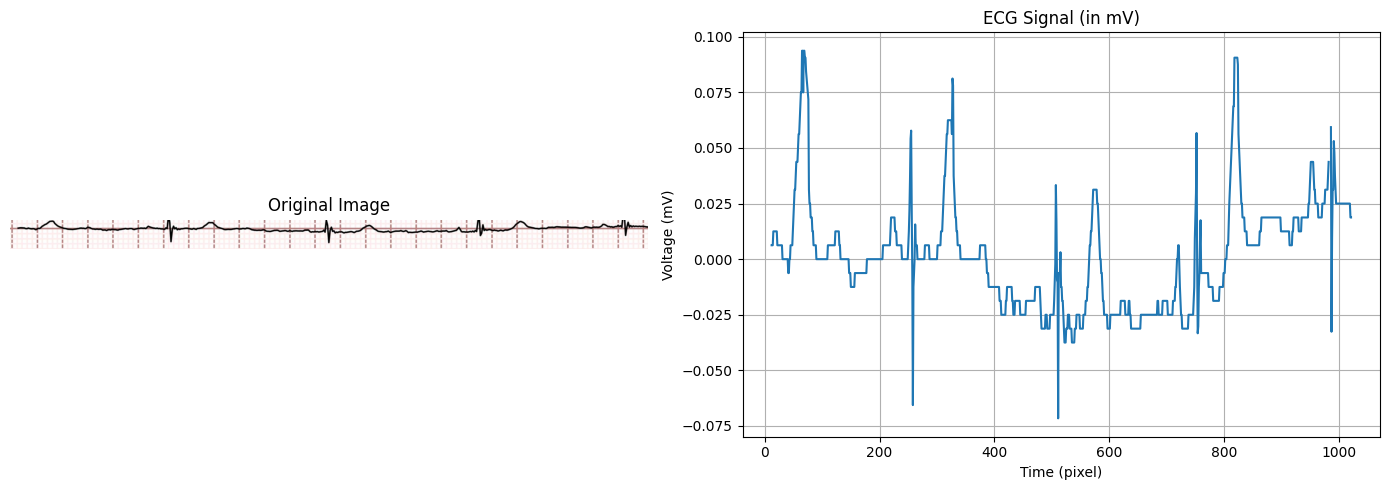

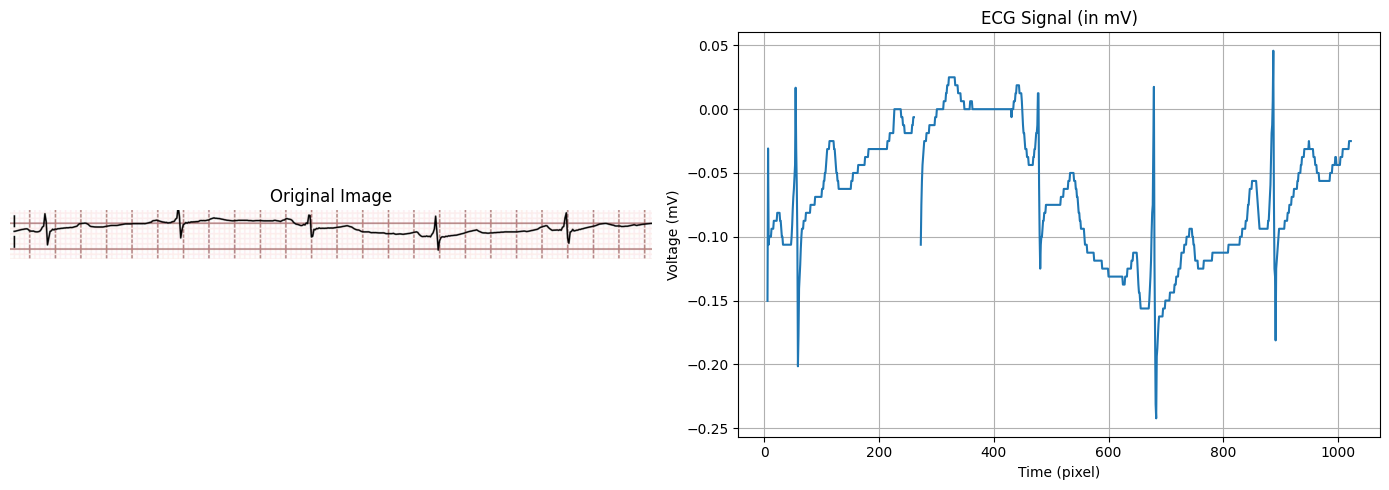

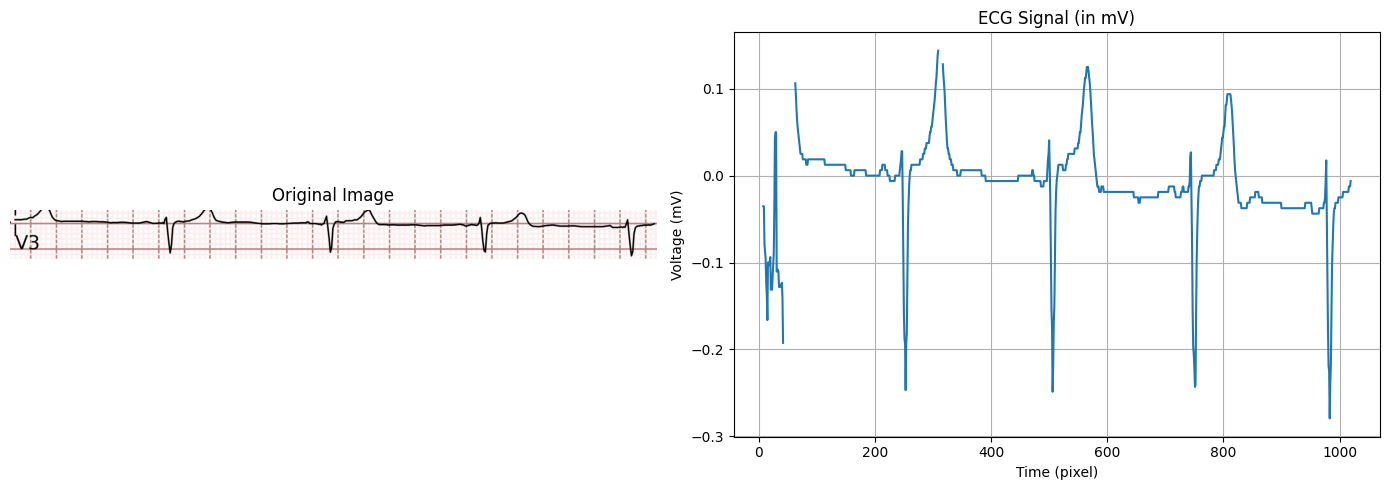

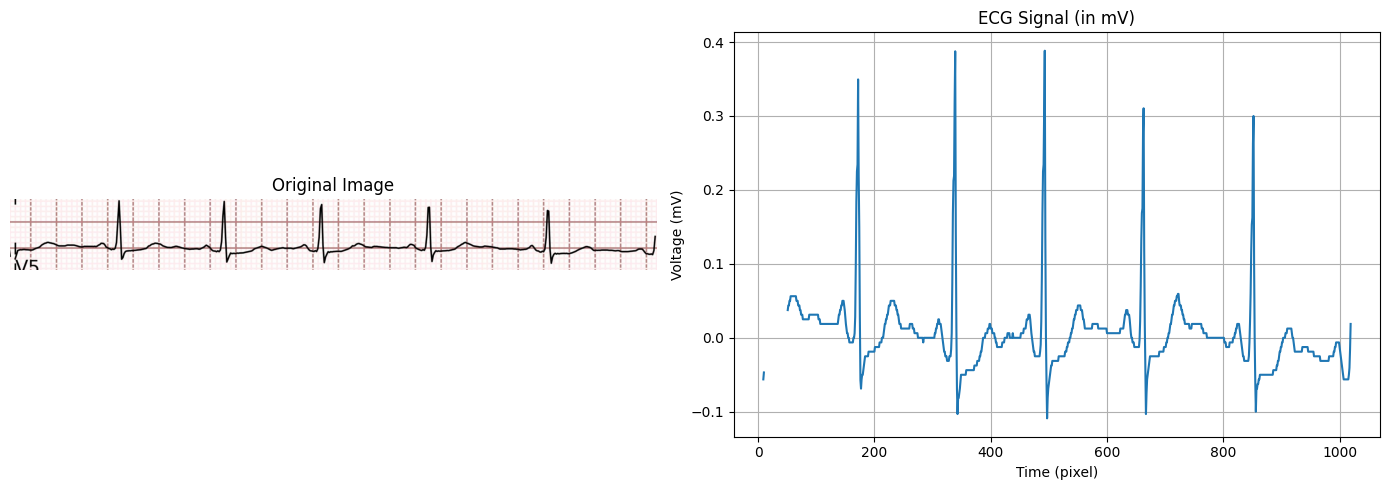

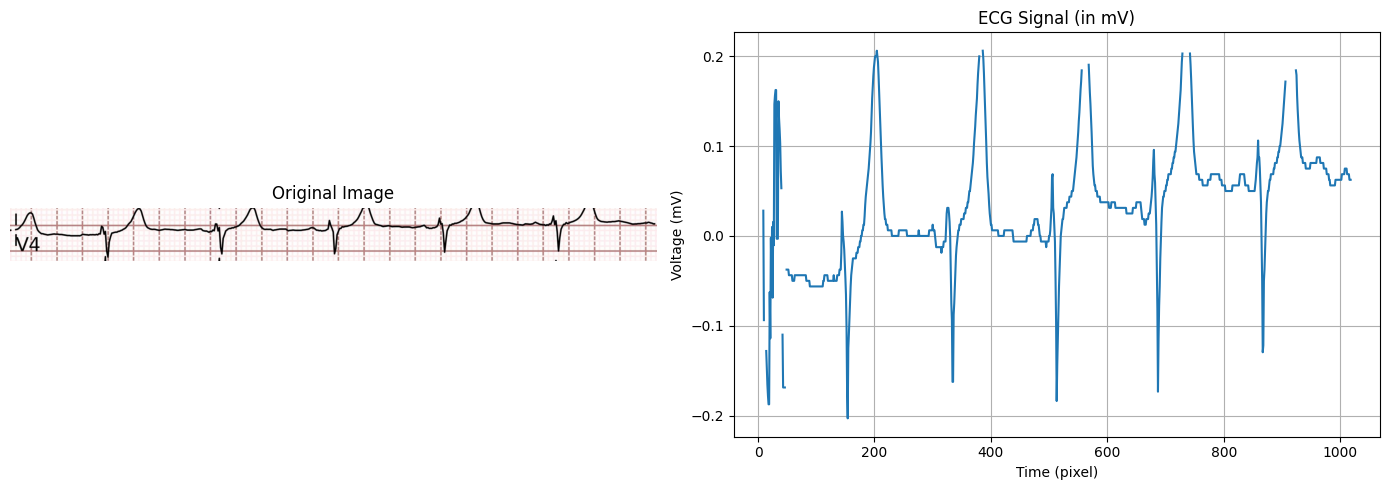

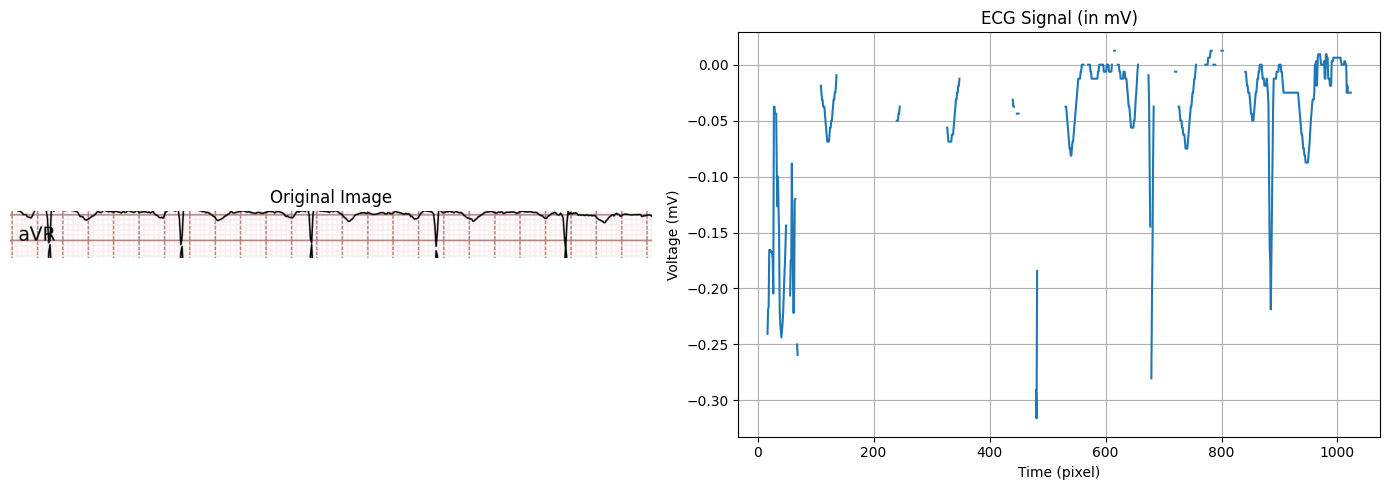

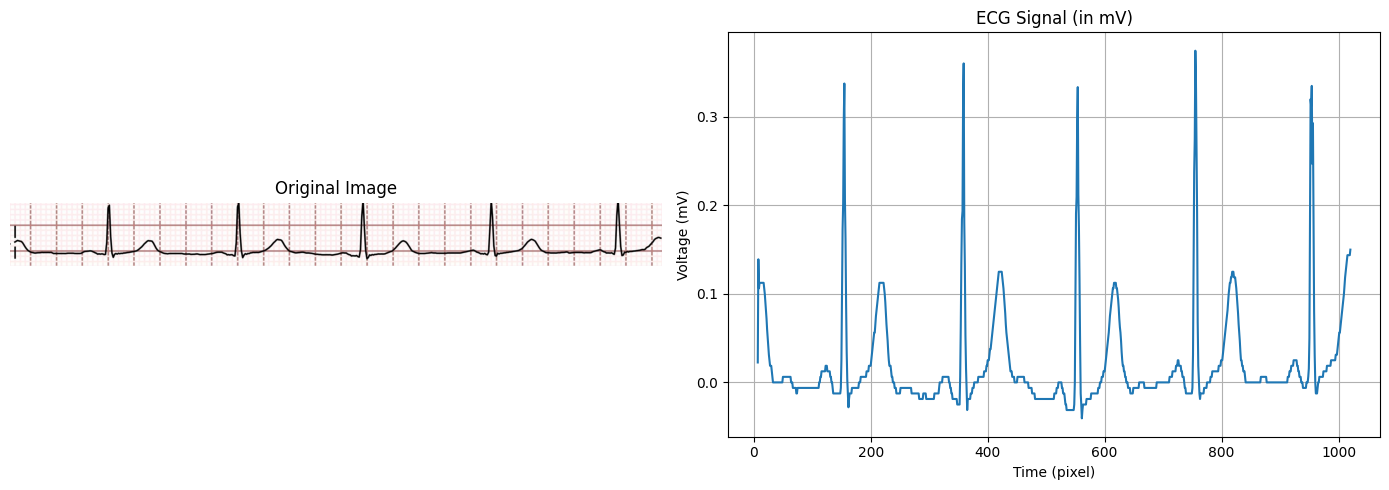

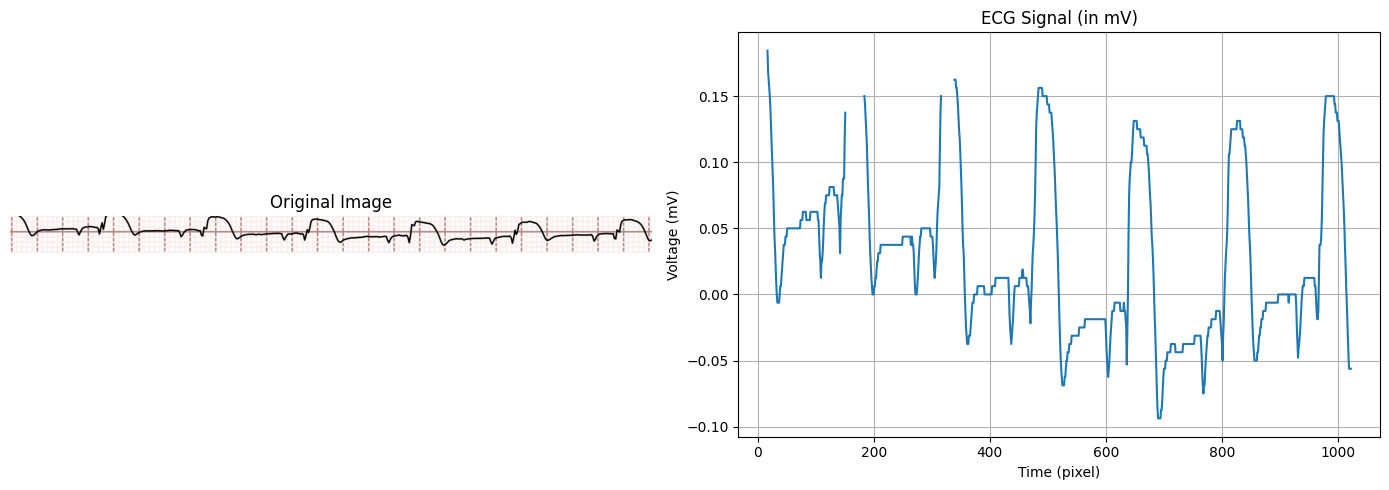

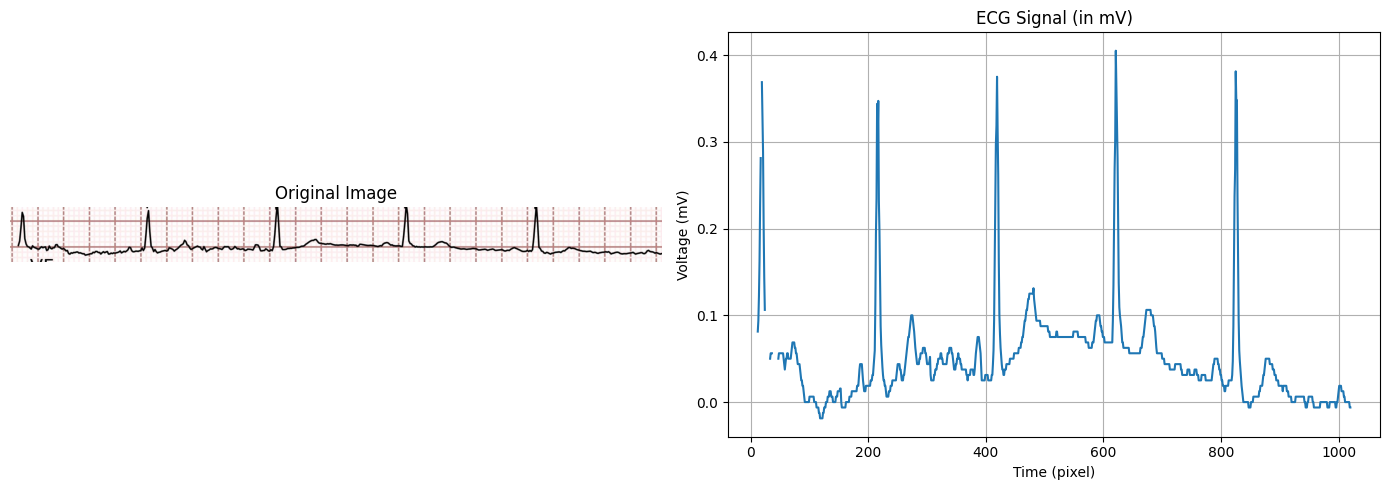

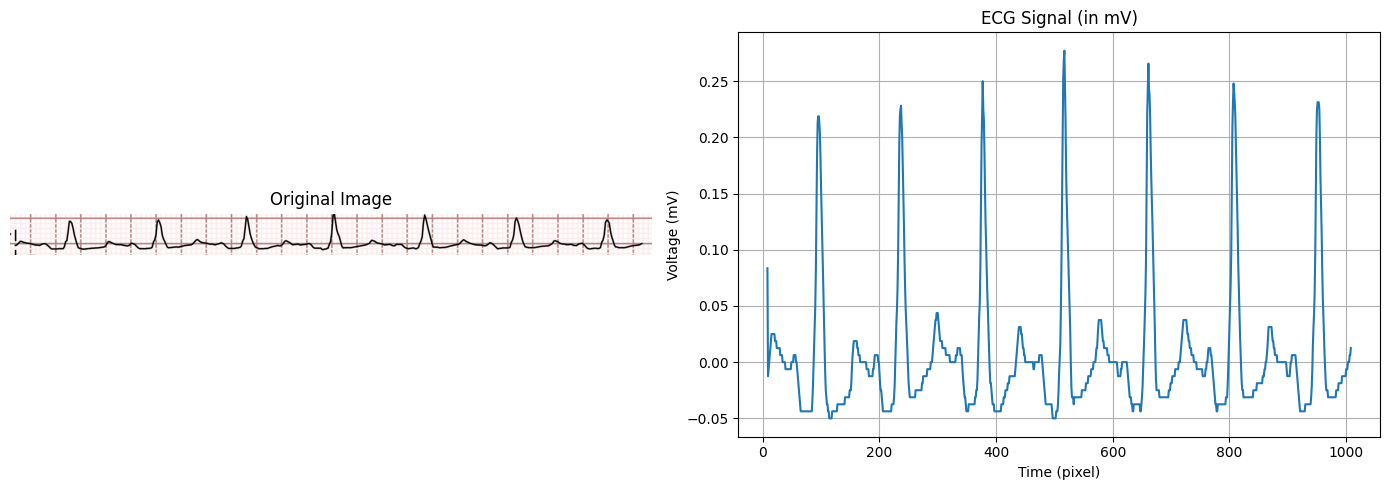

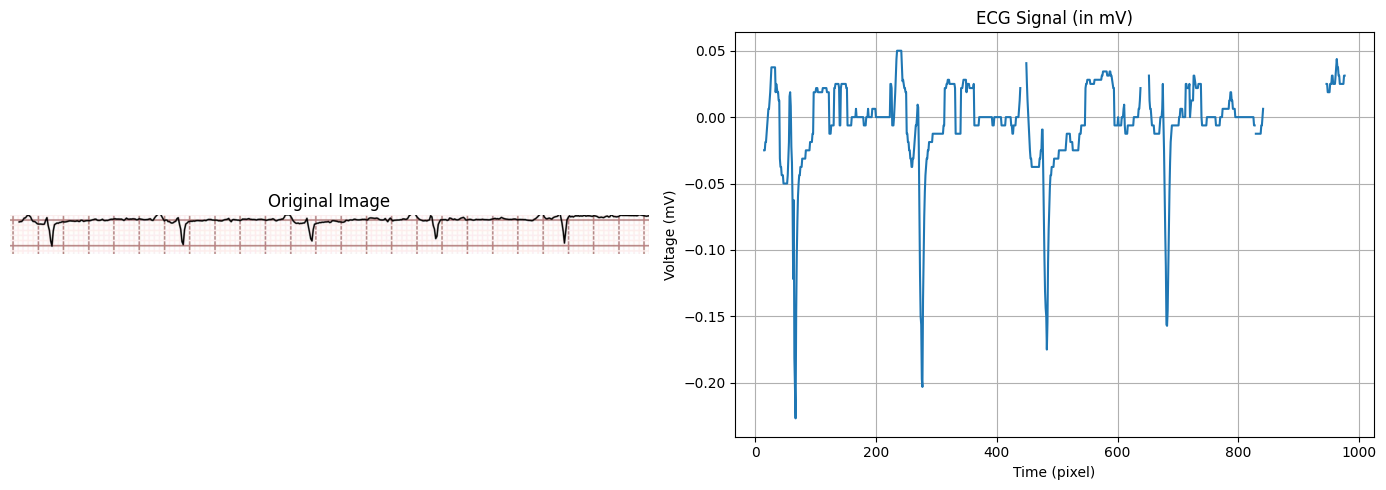

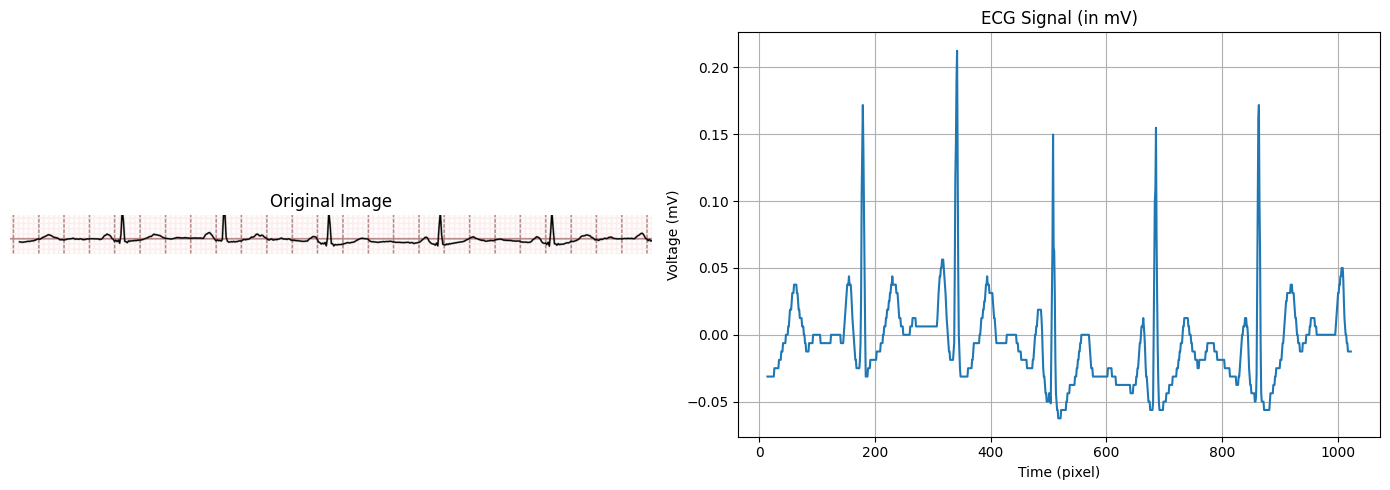

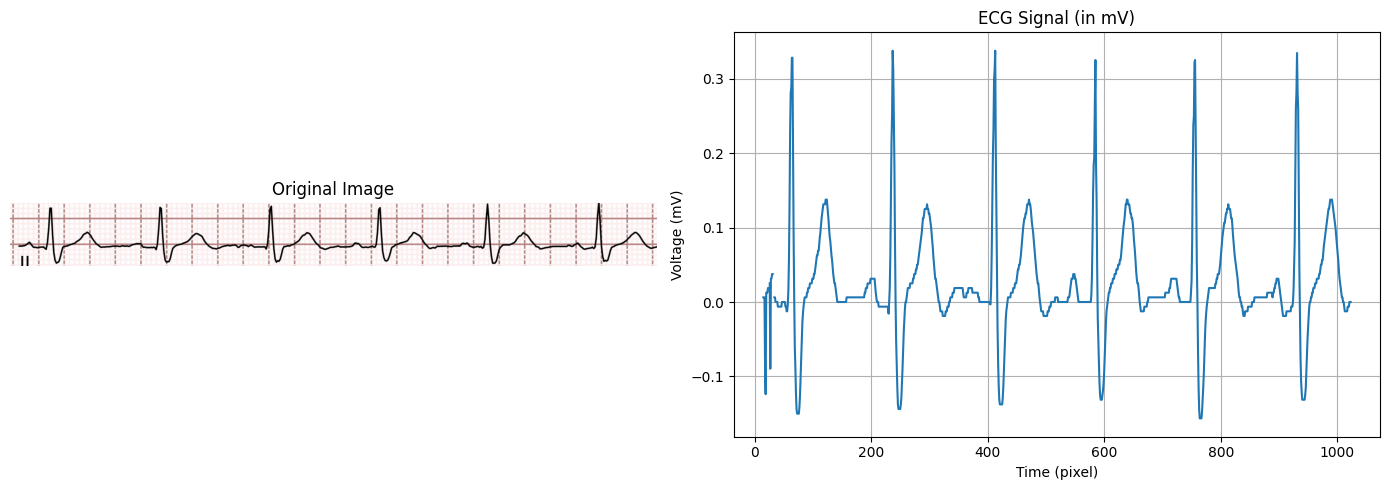

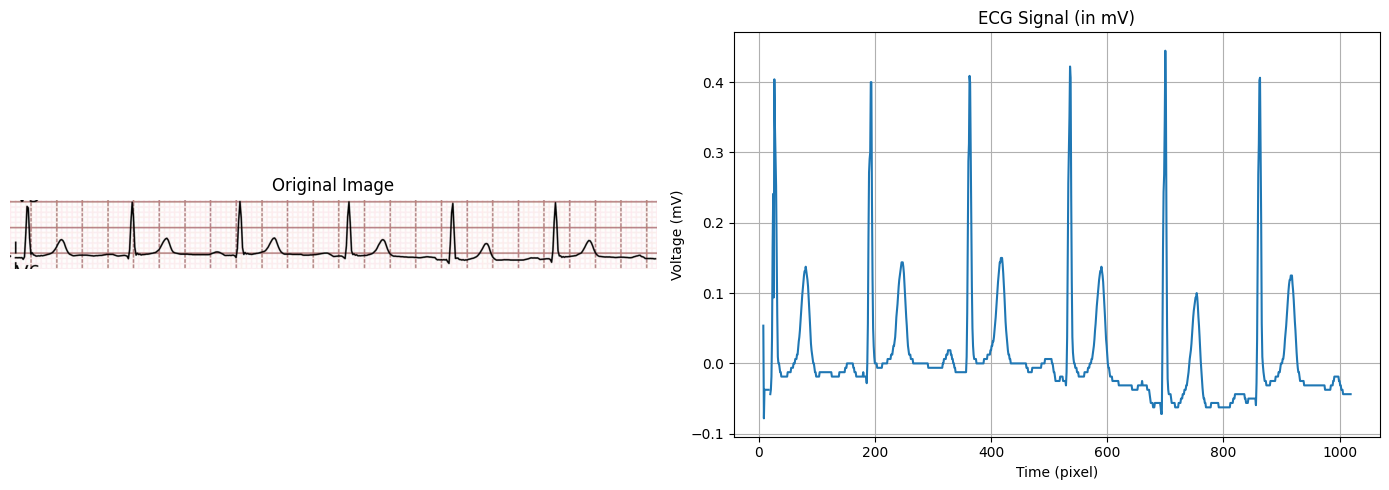

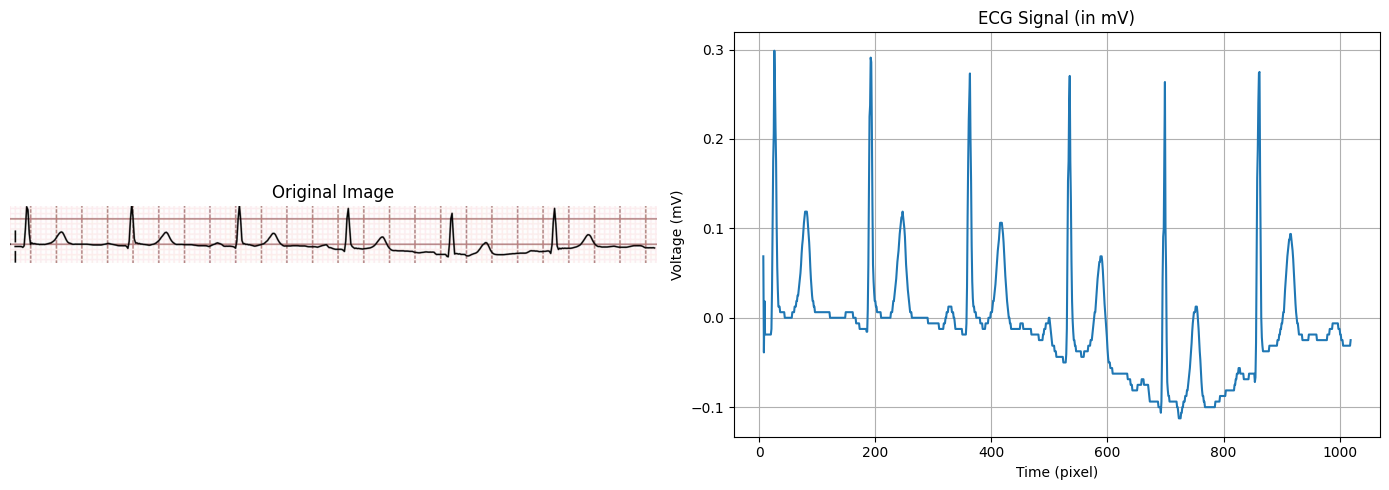

In [128]:
waveforms = []
for i in range(len(waves)):
    mask = waves[i]
    mask = (mask > 0.5).cpu().numpy().astype(np.uint8)
    mask = np.squeeze(mask)  # Remove channel dimension if present
    mask = skeletonize(mask.astype(bool)).astype(np.uint8)

    waveform = binary_mask_to_waveform(mask, square_size=sizes[i], baseline_mode='mode')
    waveforms.append(waveform)
    
    # Use the original image name for consistent naming
    orig_name = os.path.basename(valid_images[i])
    orig_base, orig_ext = os.path.splitext(orig_name)

    # Load original image for plotting
    orig_img_path = os.path.join('../data/final-outputs', f"{orig_base}{orig_ext}")
    orig_img = cv2.imread(orig_img_path)
    if orig_img is not None:
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Plot original image and waveform side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    if orig_img is not None:
        axs[0].imshow(orig_img)
        axs[0].set_title("Original Image")
        axs[0].axis('off')
    else:
        axs[0].text(0.5, 0.5, "Image not found", ha='center', va='center')
        axs[0].set_title("Original Image")
        axs[0].axis('off')

    axs[1].plot(waveform)
    axs[1].set_title("ECG Signal (in mV)")
    axs[1].set_xlabel("Time (pixel)")
    axs[1].set_ylabel("Voltage (mV)")
    axs[1].grid()
    plt.tight_layout()
    plt.show()

    # --- Save the plot ---
    plot_path = os.path.join('../data/final-outputs', f"{orig_base}_waveform_plot.png")
    fig.savefig(plot_path)
    plt.close(fig)

    # --- Save the waveform array ---
    npy_path = os.path.join('../data/final-outputs', f"{orig_base}_wave.npy")
    np.save(npy_path, waveform)

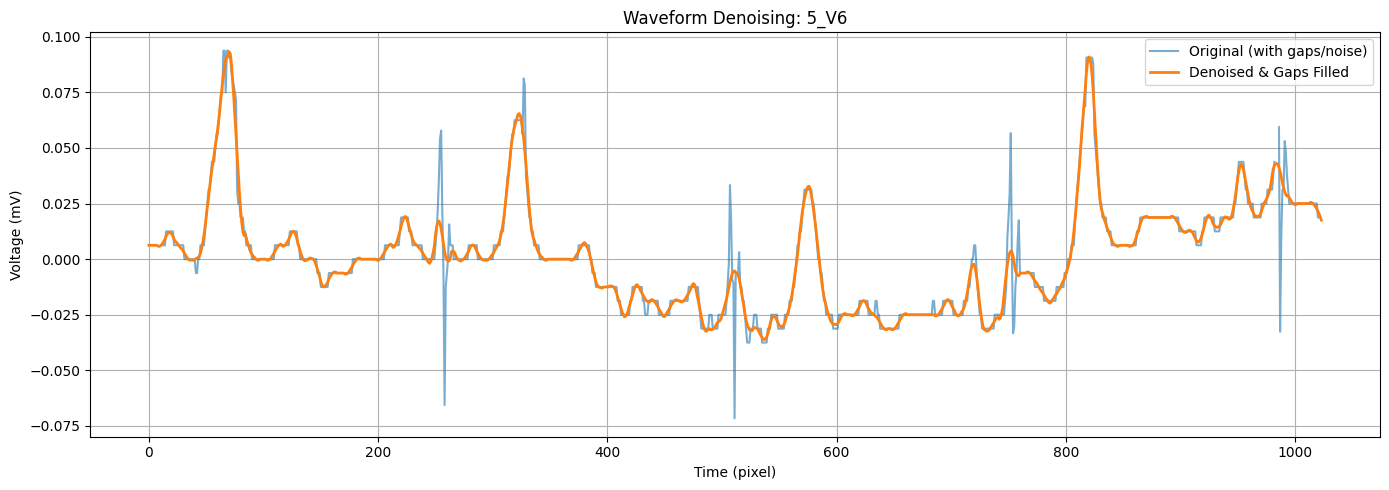

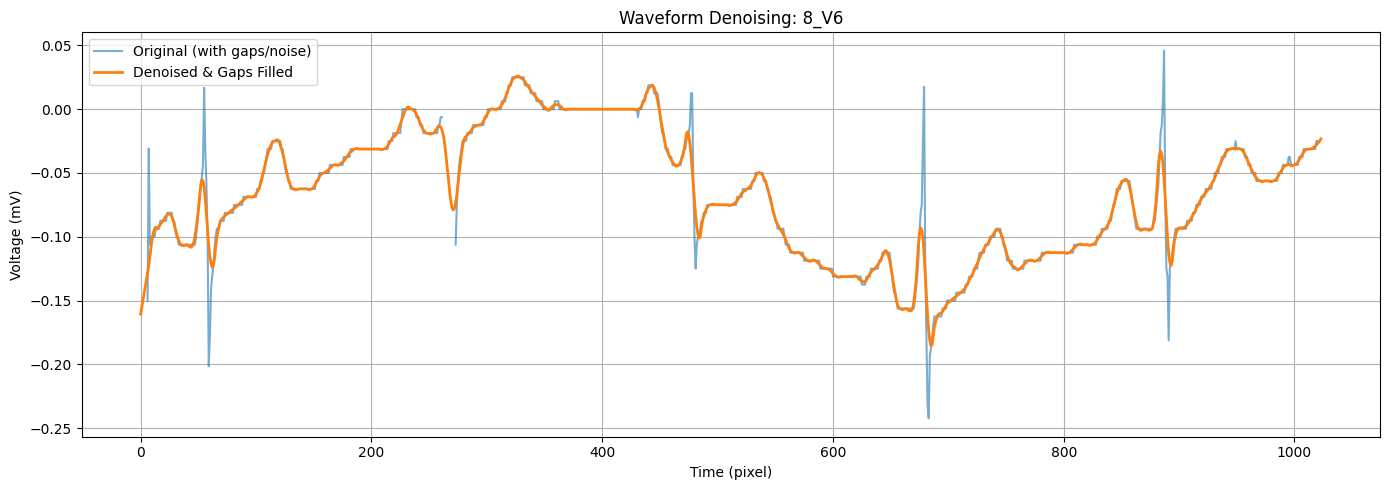

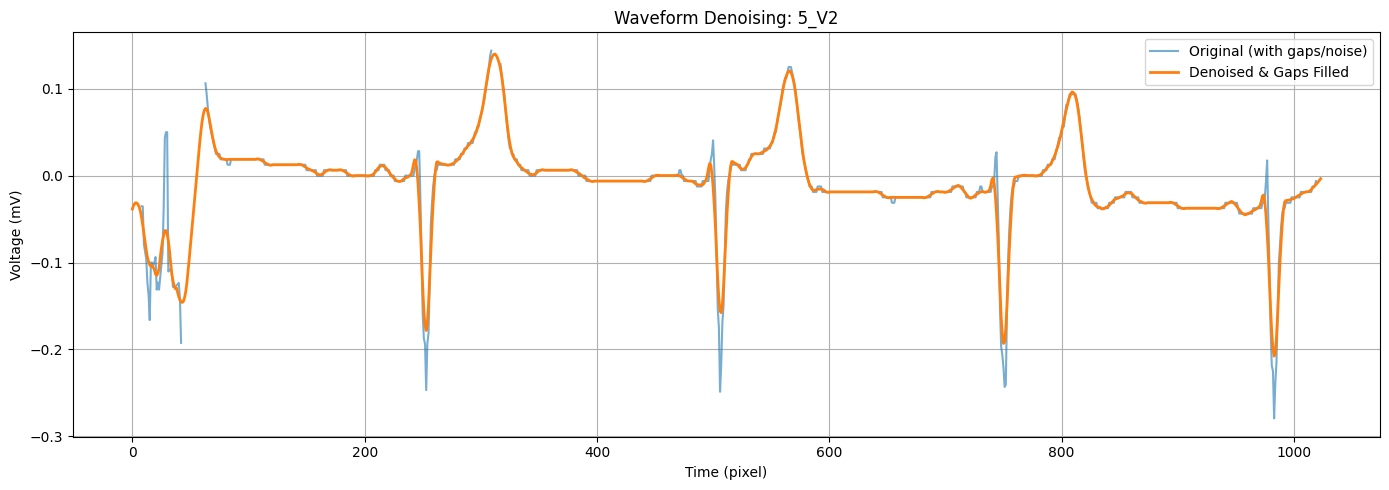

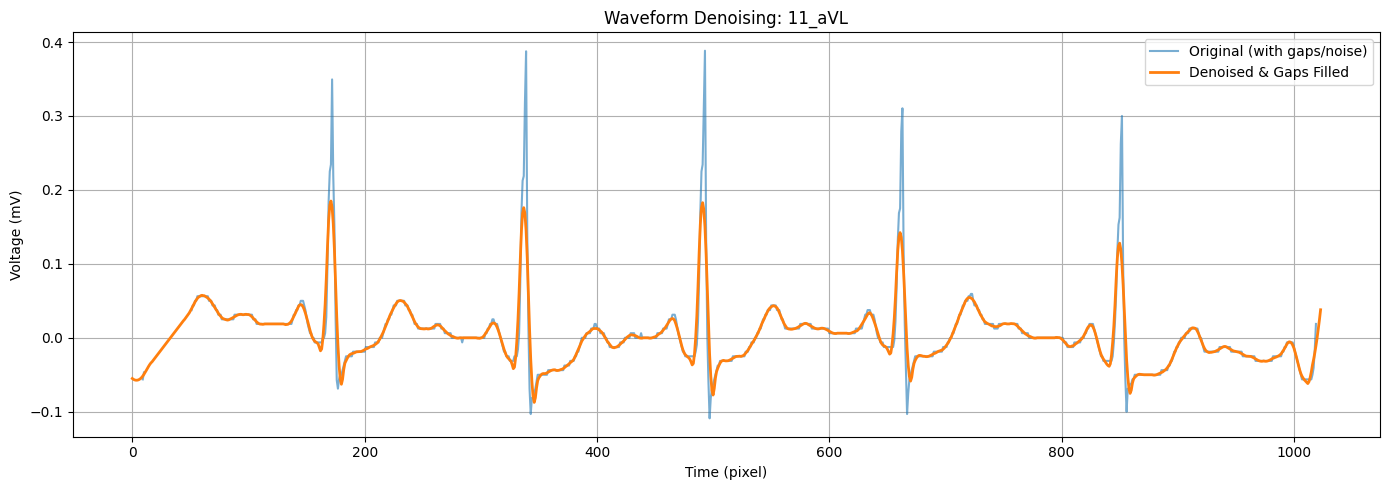

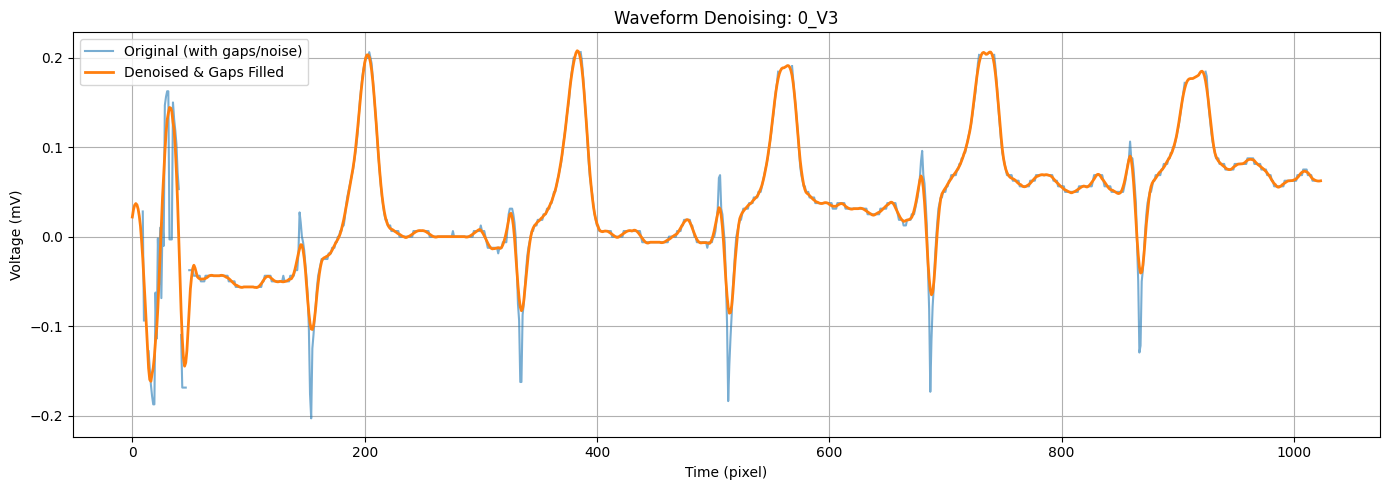

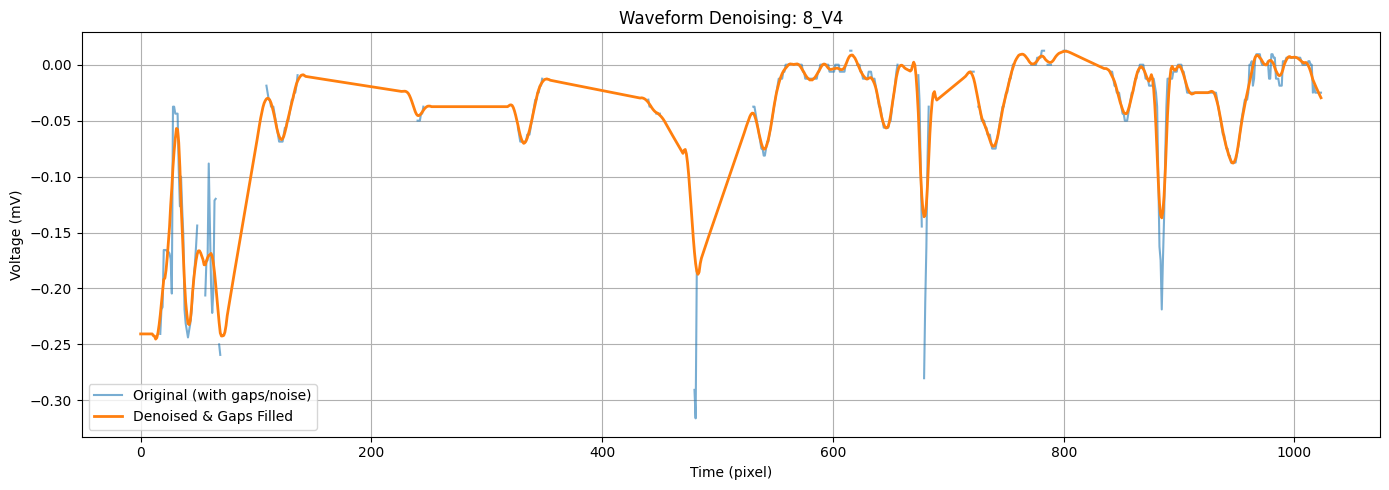

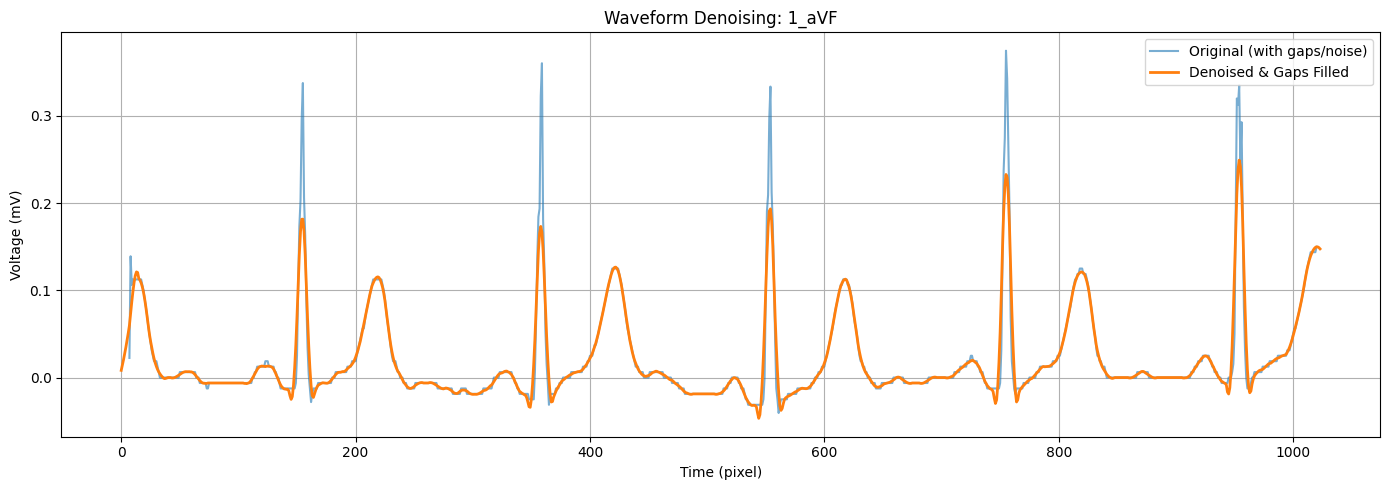

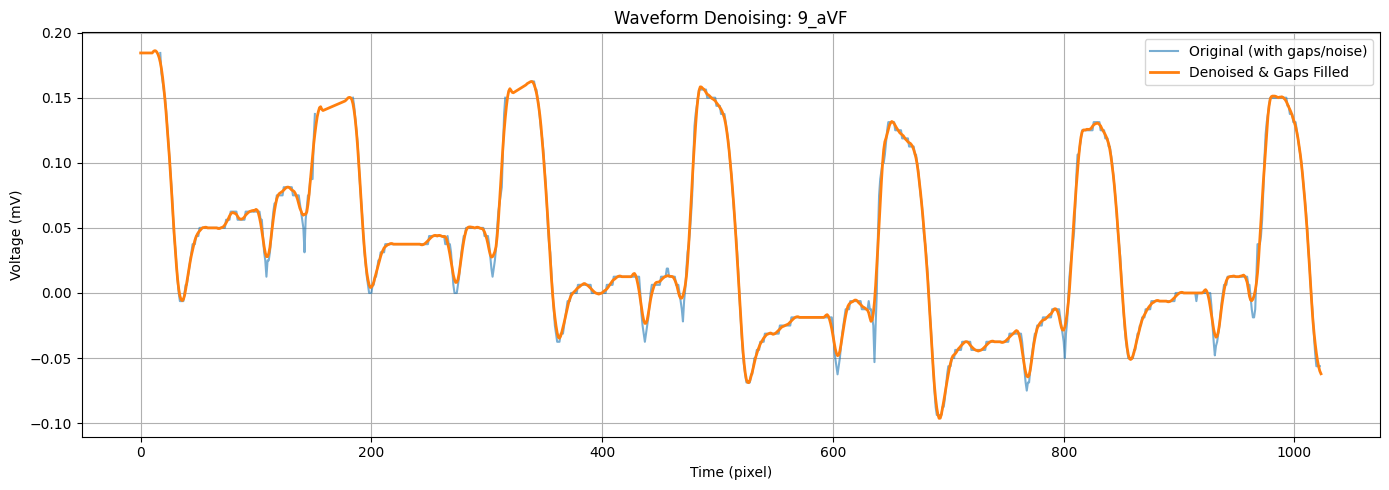

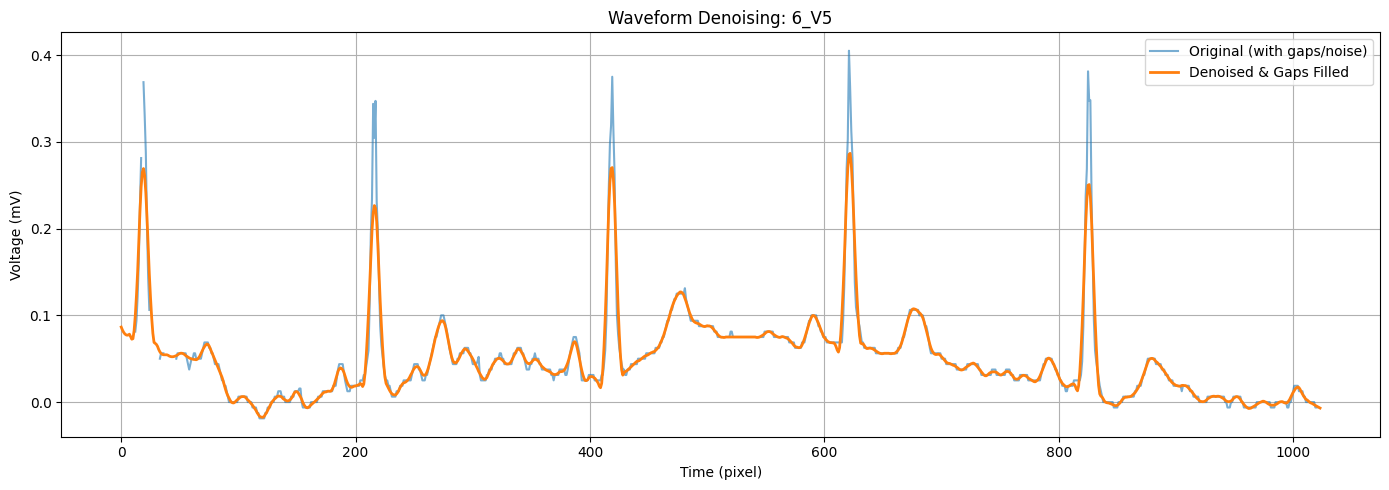

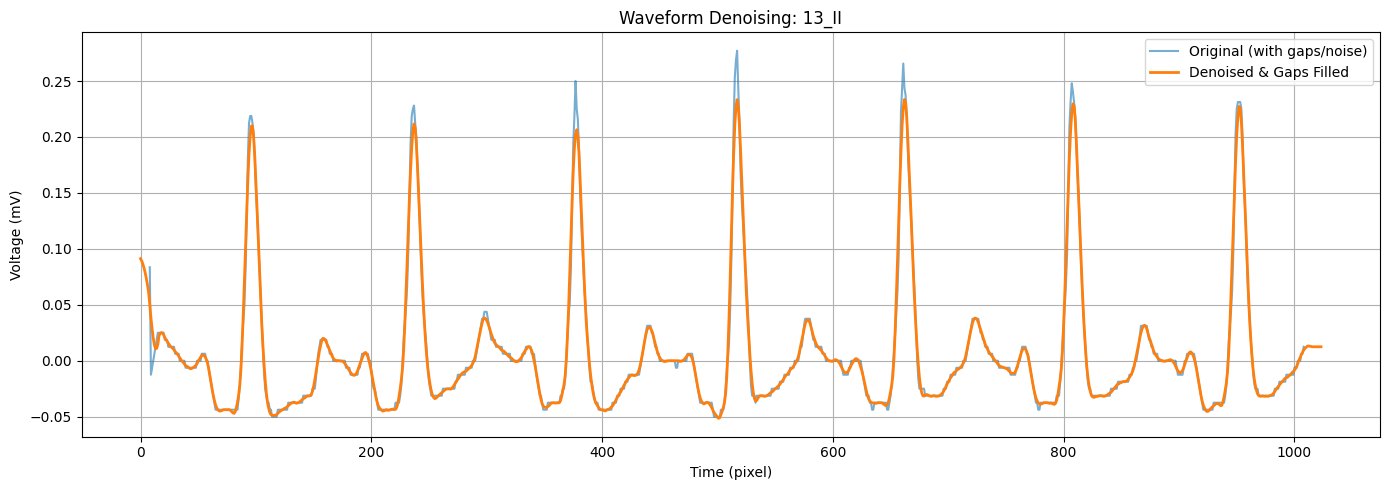

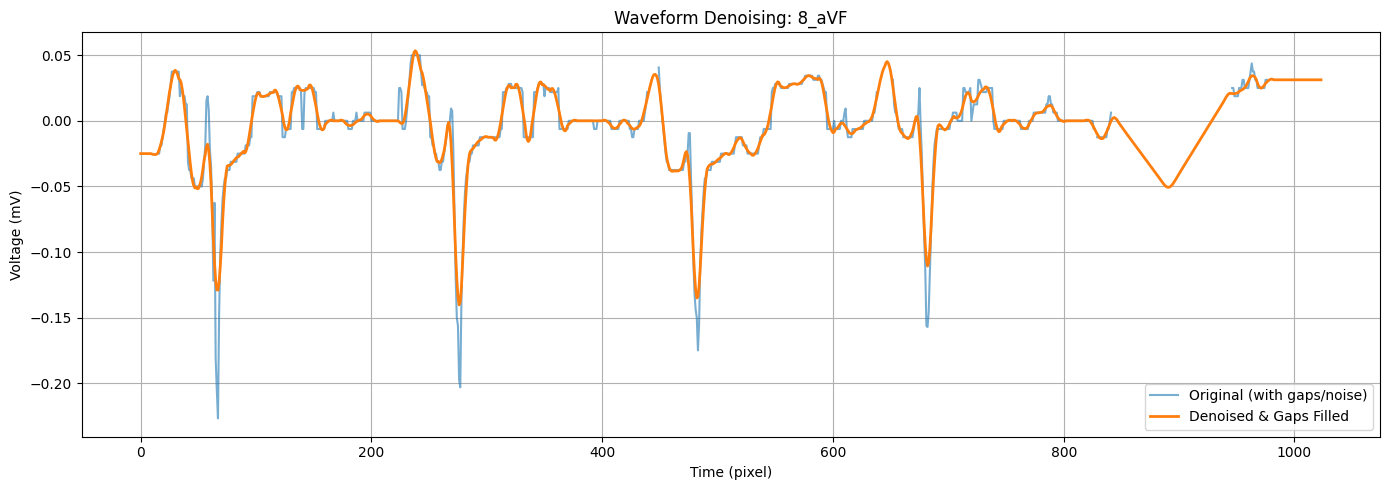

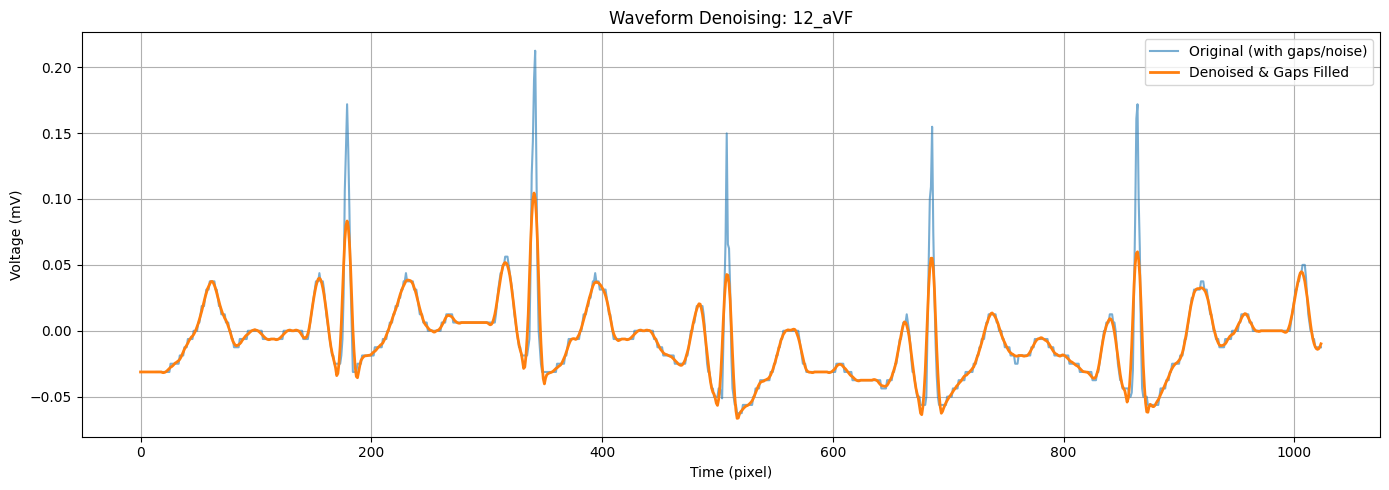

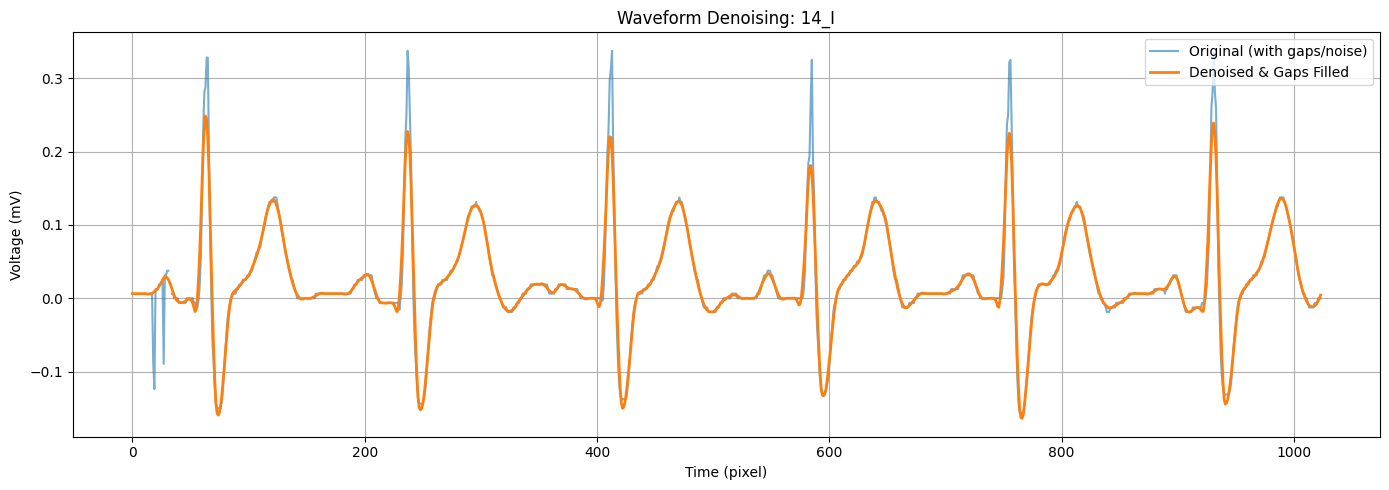

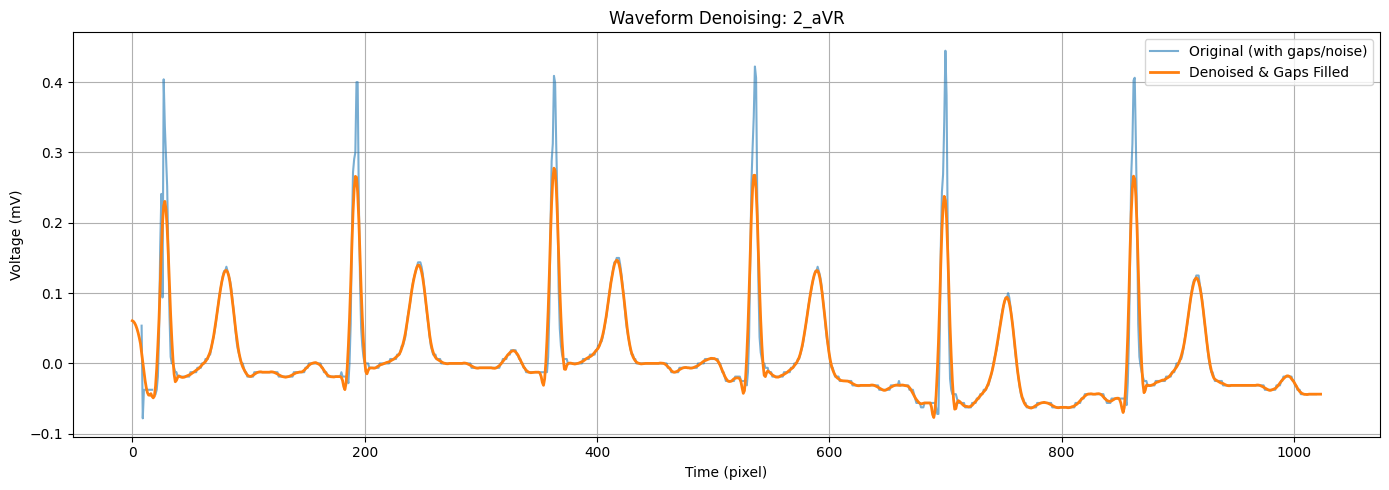

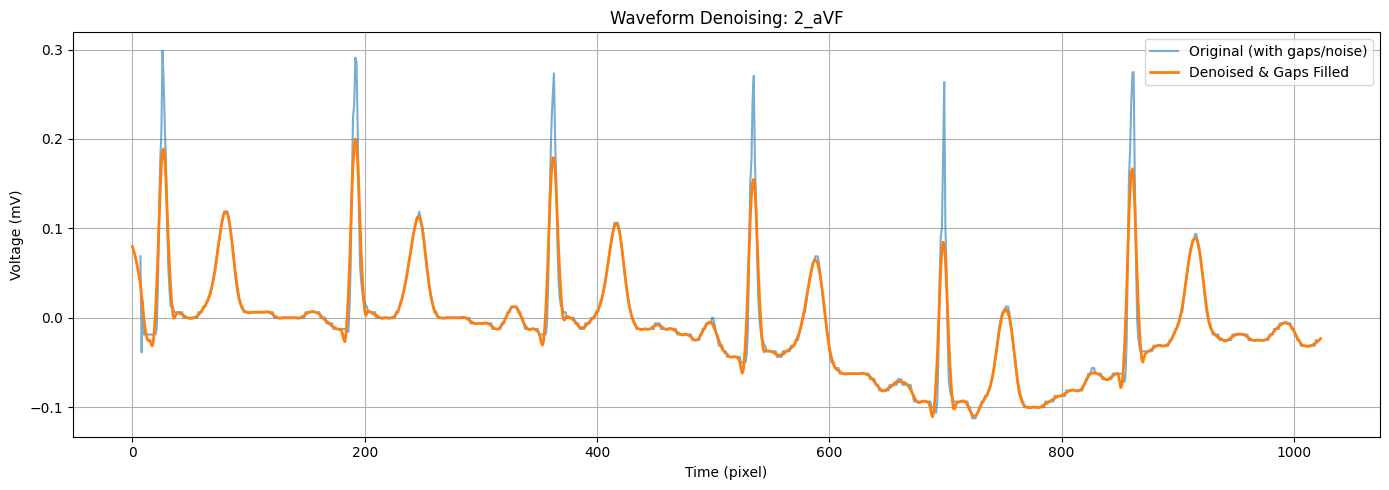

In [131]:
from scipy.signal import medfilt, savgol_filter

def fill_gaps(signal):
    """Fill NaN gaps in a 1D array using linear interpolation."""
    nans = np.isnan(signal)
    if np.any(~nans):
        signal[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), signal[~nans])
    return signal

for i, waveform in enumerate(waveforms):
    # 1. Fill gaps (NaNs)
    filled = fill_gaps(waveform.copy())

    # 2. Denoise (choose one, or both)
    # Median filter (window size should be odd and > 1)
    denoised = medfilt(filled, kernel_size=7)
    # Or: Savitzky-Golay filter for smoothing (window_length must be odd)
    denoised = savgol_filter(denoised, window_length=15, polyorder=2)

    # Plot original and denoised
    orig_name = os.path.basename(valid_images[i])
    orig_base, _ = os.path.splitext(orig_name)
    plt.figure(figsize=(14, 5))
    plt.plot(waveform, label='Original (with gaps/noise)', alpha=0.6)
    plt.plot(denoised, label='Denoised & Gaps Filled', linewidth=2)
    plt.title(f"Waveform Denoising: {orig_base}")
    plt.xlabel("Time (pixel)")
    plt.ylabel("Voltage (mV)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()